In [1]:
import numpy as np
from scipy import linalg
from scipy import integrate
from scipy import sparse
import matplotlib.pyplot as plt
import qutip as qt


In [2]:
opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}
def mkSpinOp(dims, specs):
    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)
def idOp(dims):
    return mkSpinOp(dims, [])
def zeroOp(dims):
    d = np.prod(dims)
    return qt.Qobj(sparse.csr_matrix((d, d), dtype=np.float64), 
                       dims=[list(dims)]*2, type="oper", isherm=True) 
def mkH1(dims, ind, parvec):
    axes = ['x', 'y', 'z']
    components = [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0]
    if components:
        return sum(components)
    else:
        return zeroOp(dims)
def mkH12(dims, ind1, ind2, parmat):
    axes = ['x', 'y', 'z']
    components = []
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                components.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    if components:
        return sum(components)
    else:
        return zeroOp(dims)
    

In [3]:
def point_dipole_dipole_coupling(r):

    # H = - \frac{ \mu_0 }{ 4 \pi } \frac{ \gamma_j \gamma_k \hbar^2}{ r_{jk}^3 }
    #       \left( 3 (\bold{I}_j \cdot \bold{e}_{jk})  (\bold{I}_k \cdot \bold{e}_{jk}) - \bold{I}_j \cdot \bold{I}_k \right)

    dr3 = -4*np.pi*1e-7 * (2.0023193043617 * 9.27400968e-24)**2 / (4*np.pi*1e-30)/6.62606957e-34/1e6 # MHz * A^3

    if np.isscalar(r):
        # assume r is aligned with z
        d = dr3 / r**3
        A = np.diag([-d, -d, 2*d])
    else:
        norm_r = np.linalg.norm(r)
        d = dr3 / norm_r**3
        e = r / norm_r
        A = d * (3 * e[:,np.newaxis] * e[np.newaxis,:] - np.eye(3))

    return A

In [4]:
g = 2.00231930436256 #electron g-factor
beta = 9.274009994e-24 #bohr magneton
hbar = 6.62607015e-34/(2*np.pi) #hbar

# hfcs: mT -> Mrad/s

N5 = g*beta/hbar*1e-9 * np.array([[-0.0994933,   0.00287092, 0],
                                  [0.00287092, -0.0874862,  0.], 
                                  [0.,          0.,         1.75687]])

N1 = g*beta/hbar*1e-9 * np.array([[-0.0529598, -0.0586562, 0.0460172], 
                                  [-0.0586562,  0.564443, -0.564764],
                                  [0.0460172, -0.564764,  0.453074]])

Is = [1, 1]
As = [N5, N1]
indE = [0, 1]

#Is = [1]
#As = [N5]
#indE = [0]

rFW = np.array([  8.51061  , -14.251621 ,   6.5492562])
Dee = point_dipole_dipole_coupling(rFW) * 2*np.pi # Mrad/s
Dee = 0 * Dee

b0 = 1.4 * 2*np.pi

kb = 2. # 1/us
kf = 1. # 1/us

In [5]:
dims = [2, 2, *[round(2*I+1) for I in Is]]
temp = mkH12(dims, 0, 1, np.identity(3))
print(temp)
Ps = 1/4 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.identity(3))
 # Ps = 1/4 - S1 . S2 = 1/4 - S1xS2x - S1yS2y ...
one = mkSpinOp(dims,[])
Pt = one - Ps
Hhfc = sum(mkH12(dims, indE[i], i+2, As[i]) for i in range(len(As)))
Hdee = mkH12(dims, 0, 1, Dee)
K = kb/2 * Ps + kf/2 * one
rho0 = Ps/Ps.tr()
H0 = Hhfc + Hdee

Quantum object: dims = [[2, 2, 3, 3], [2, 2, 3, 3]], shape = (36, 36), type = oper, isherm = True
Qobj data =
[[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]


C:\Users\bptig\AppData\Local\Temp\ipykernel_1828\873698272.py:18: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  yr = kb * integrate.simps(ps, tlist)


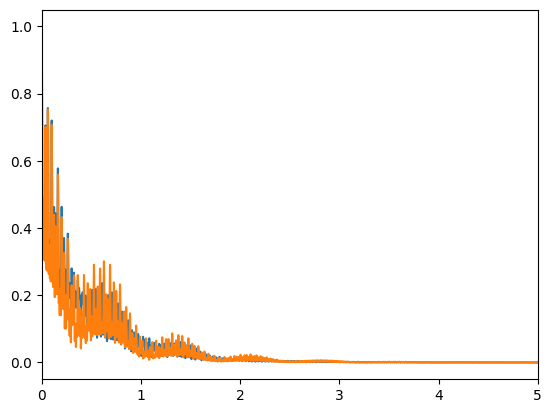

[0.4509856418927456, 0.40158067015777277]

In [6]:
oris = [np.array([0, 0, 1]), np.array([1, 0, 0])]

tmax = 20. / kf # us
tlist = np.linspace(0, tmax, int(np.ceil(1000*tmax)))

opt = qt.Options()
opt.atol = 1e-10
opt.rtol = 1e-8

yields = []
for ori in oris:
    b0vec = ori * b0
    Hzee = mkH1(dims, 0, b0vec) + mkH1(dims, 1, b0vec)
    Heff = H0 + Hzee - 1j * K
    Leff = -1j*qt.spre(Heff) + 1j*qt.spost(Heff.conj().trans())
    sol = qt.mesolve(Leff, rho0, tlist, e_ops=[Ps], options=opt)
    ps = sol.expect[0]
    yr = kb * integrate.simps(ps, tlist)
    yields.append(yr)
    plt.plot(tlist, ps)

ax = plt.gca()
ax.set_xlim([0,5])
plt.show()
yields